In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation, MeanShift, SpectralClustering, HDBSCAN

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score

from feature_extraction import method_flagger # Used for creating our methodology flags

In [2]:
pollsters = pd.read_csv('../data/pollster-ratings.csv')
polls = pd.read_csv('../data/raw-polls-updated.csv')

df = pd.merge(left = polls, right = pollsters, how = 'left', left_on = 'pollster_rating_id', right_on = 'Pollster Rating ID')

df = pd.merge(df, 
              pd.DataFrame(method_flagger(df['methodology'])), 
              left_index=True, 
              right_index=True)

df['days_bt_polldate_election'] = (pd.to_datetime(df['electiondate']) - pd.to_datetime(df['polldate'])).dt.days

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10776 entries, 0 to 10775
Data columns (total 69 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   poll_id                                       10776 non-null  int64  
 1   question_id                                   10776 non-null  int64  
 2   race_id                                       10776 non-null  int64  
 3   year                                          10776 non-null  int64  
 4   race                                          10776 non-null  object 
 5   location                                      10776 non-null  object 
 6   type_simple                                   10776 non-null  object 
 7   type_detail                                   10776 non-null  object 
 8   pollster                                      10776 non-null  object 
 9   pollster_rating_id                            10776 non-null 

In [4]:
df.isna().sum()[df.isna().sum() > 0] 
# We have some missing values from our merge, we can drop those later once we've selected our features.
# Most NAs are from incomplete information from the pollster ratings data so we have no way to impute or otherwise fix
# those observations. We will drop only the rows with incomplete information for the features we select.
# Partisan has missing values for non-partisan polls (with 1 exception)
# Cand3_pct and comment are only used as necessary
# Bias has a number of missing values which is unexpected but can be easily imputed
# We will use 'calc_bias' which is margin_poll - margin_actual as describe in the data dictionary

partisan                                        9957
cand3_pct                                       6879
bias                                            1952
comment                                         6711
Rank                                              21
Pollster                                          21
Pollster Rating ID                                21
Polls Analyzed                                    21
AAPOR/Roper                                       21
Banned by 538                                     21
Predictive Plus-Minus                             21
538 Grade                                         21
Mean-Reverted Bias                               128
Races Called Correctly                            21
Misses Outside MOE                                21
Simple Average Error                              21
Simple Expected Error                             21
Simple Plus-Minus                                 21
Advanced Plus-Minus                           

In [5]:
df['calc_bias'] = df['margin_poll'] - df['margin_actual']

In [6]:
np.mean(df['error'] - np.abs(df['calc_bias'])) # about as accurate as we can get

-9.27550055675687e-07

In [7]:
df.columns

Index(['poll_id', 'question_id', 'race_id', 'year', 'race', 'location',
       'type_simple', 'type_detail', 'pollster', 'pollster_rating_id',
       'methodology', 'partisan', 'polldate', 'samplesize', 'cand1_name',
       'cand1_id', 'cand1_party', 'cand1_pct', 'cand2_name', 'cand2_id',
       'cand2_party', 'cand2_pct', 'cand3_pct', 'margin_poll', 'electiondate',
       'cand1_actual', 'cand2_actual', 'margin_actual', 'error', 'bias',
       'advancedplusminus', 'comment', 'state', 'state_agg', 'imputed_600',
       'anon', 'registered_voters', 'averaged', 'org', 'person', 'rightcall',
       'Rank', 'Pollster', 'Pollster Rating ID', 'Polls Analyzed',
       'AAPOR/Roper', 'Banned by 538', 'Predictive Plus-Minus', '538 Grade',
       'Mean-Reverted Bias', 'Races Called Correctly', 'Misses Outside MOE',
       'Simple Average Error', 'Simple Expected Error', 'Simple Plus-Minus',
       'Advanced Plus-Minus', 'Mean-Reverted Advanced Plus-Minus',
       '# of Polls for Bias Analysis', 

In [8]:
def partisan_mapper(party):
    if party in ['D', 'R']:
        return party
    return 'N/A'

def partisan_selector(df):
    df['partisan'] = df.loc[:, 'partisan'].apply(partisan_mapper)
    return df

In [14]:
features = [
    'year',
    'type_simple',
    'partisan',
    'samplesize',
    'margin_poll',
    'advancedplusminus',
    'imputed_600',
    'anon',
    'registered_voters',
    'averaged',
    #'polls_analyzed',
    'Text',
    'Live Phone',
    'Mail',
    'Face-to-Face',
    'IVR',
    'Online',
    'error',
    'calc_bias',
    'days_bt_polldate_election'
]

X = partisan_selector(df[features])

C:\Users\vijay\AppData\Local\Temp\ipykernel_27388\23041433.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['partisan'] = df.loc[:, 'partisan'].apply(partisan_mapper)


In [15]:
df.groupby('rightcall')[['error', 'calc_bias']].agg(['mean', 'std'])

error           calc_bias          
               mean       std      mean       std
rightcall                                        
0.0        7.848711  5.555297 -1.469146  9.504525
0.5        4.477450  3.803525 -0.547500  5.853555
1.0        5.028303  4.585901  0.208541  6.802491

In [16]:
df[['error', 'calc_bias', 'rightcall']].corr()

,error,calc_bias,rightcall
error,1.000000,-0.153585,-0.212058
calc_bias,-0.153585,1.000000,0.087820
rightcall,-0.212058,0.087820,1.000000


In [12]:
X['partisan']

0        N/A
1        N/A
2          D
3        N/A
4          D
        ... 
10771      R
10772    N/A
10773      R
10774    N/A
10775      R
Name: partisan, Length: 10776, dtype: object

In [17]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

kmeans_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        ('kmeans', KMeans(n_init = 10, random_state = 42))
    ]
)

In [18]:
kmeans_pipe.fit(X)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('patrisan_ct',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['partisan',
                                                   'type_simple'])])),
                ('min_max', MinMaxScaler()),
                ('kmeans', KMeans(n_init=10, random_state=42))])

In [19]:
kmeans_pipe['kmeans'] # type: ignore

KMeans(n_init=10, random_state=42)

In [20]:
clustered = pd.concat([X, pd.Series(kmeans_pipe['kmeans'].labels_, name = 'cluster')], axis = 1) # type: ignore

In [21]:
clustered.groupby('cluster')['calc_bias'].agg(['mean', 'count'])

,mean,count
cluster,,
0,2.743595,893
1,-1.775473,1977
2,-1.312824,1962
3,-0.787598,870
4,0.052546,1296
5,0.481553,1442
6,1.539361,1079
7,0.478210,1257


c:\Users\vijay\anaconda3\envs\project-5\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


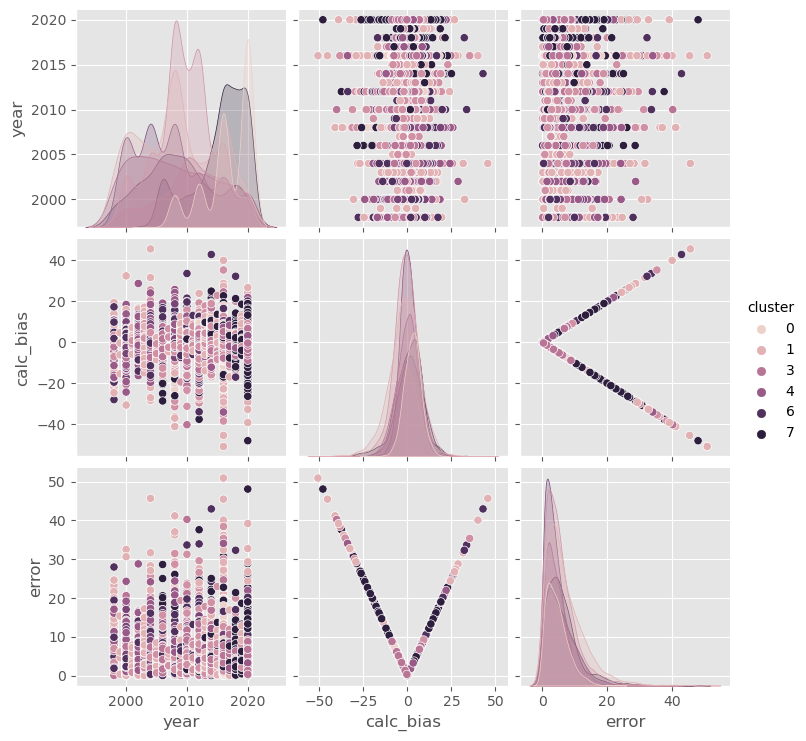

In [22]:
sns.pairplot(
    data = clustered[['year','calc_bias', 'error', 'cluster']],
    hue = 'cluster'
);

In [23]:
silhouette_score(kmeans_pipe.transform(X), clustered['cluster'])

0.4554382244811696

In [26]:
score = []

for k in range(2, 31):#[2, 19] + list(range(20, 31)):
    cl  = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        ('kmeans', KMeans(n_clusters = k, n_init = 30, random_state = 42))
    ]
)
    cl.fit(X)

    sil = silhouette_score(cl.transform(X), cl['kmeans'].labels_) # type: ignore

    score.append((k, cl['kmeans'].inertia_, sil)) # type: ignore

score_df = pd.DataFrame(score, columns = ['k', 'inertia', 'silhouette_score'])

score_df

,k,inertia,silhouette_score
0,2,14508.375112,0.621780
1,3,12482.640407,0.595166
2,4,11148.350989,0.497979
3,5,9984.442252,0.451275
4,6,9007.346353,0.438209
5,7,8329.612124,0.448046
6,8,7700.867311,0.460429
7,9,7165.659124,0.473192
8,10,6647.724596,0.495110
9,11,6191.841982,0.507607


In [27]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

kmeans_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        ('kmeans', KMeans(n_init = 30, n_clusters = 22, random_state = 42))
    ]
).fit(X)


clustered = pd.concat([X, pd.Series(kmeans_pipe['kmeans'].labels_, name = 'cluster')], axis = 1) # type: ignore # type: ignore
silhouette_score(kmeans_pipe.transform(X), clustered['cluster'])

0.6275961168835263

In [28]:
clustered.groupby('cluster')['calc_bias'].agg(['mean', 'std', 'count'])

,mean,std,count
cluster,,,
0,-3.338105,10.147936,1029
1,0.203248,6.738602,819
2,2.467811,4.659742,169
3,-0.405563,5.792483,453
4,-0.159839,6.777523,1118
5,-4.229028,9.973012,72
6,1.596739,6.813752,509
7,0.422995,4.982858,1132
8,1.544592,6.701977,797


c:\Users\vijay\anaconda3\envs\project-5\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


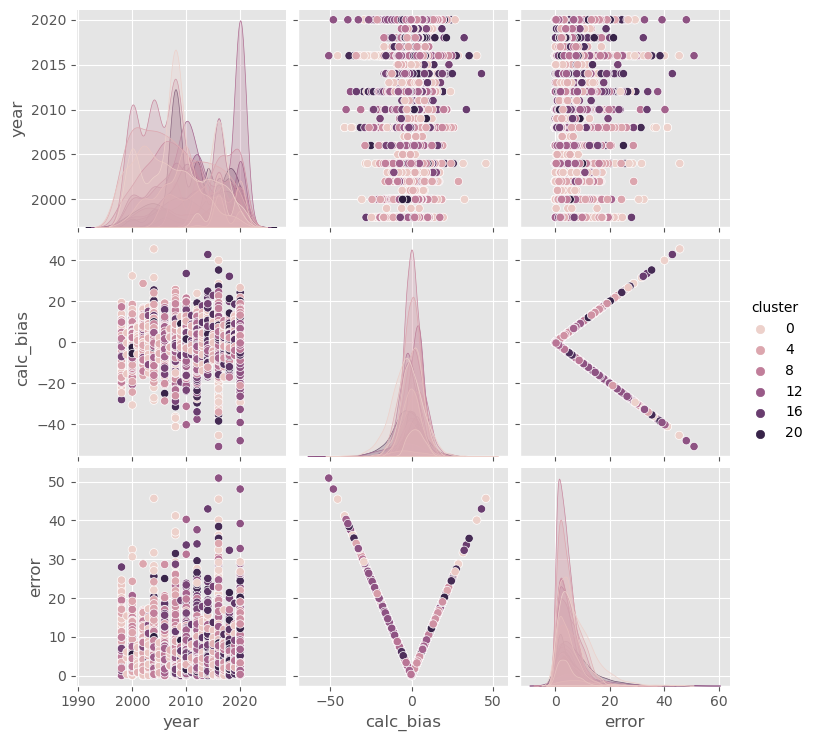

In [29]:
sns.pairplot(
    data = clustered[['year','calc_bias', 'error', 'cluster']],
    hue = 'cluster'
);

In [22]:
clustered.groupby(['partisan', 'cluster'])['partisan'].count()

partisan  cluster
D         0             1
          1             6
          8             3
          10            5
          11            3
          12          126
          13          156
          15            1
          17          127
          18            8
          19           14
          20            1
N/A       0           165
          1          1126
          2           599
          3          1029
          4          1118
          5           169
          6           821
          7           487
          8           819
          9           240
          10          332
          11          687
          14          453
          15          643
          16          225
          18          501
          19          210
          20          182
          21          152
R         10            9
          12          110
          13          129
          17          119
Name: partisan, dtype: int64

In [30]:
score = []

for k in range(2, 31):
    cl  = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('ss', StandardScaler()),
        ('kmeans', KMeans(n_clusters = k, n_init = 30, random_state = 42))
    ]
)
    cl.fit(X)

    sil = silhouette_score(cl.transform(X), cl['kmeans'].labels_) # type: ignore

    score.append((k, cl['kmeans'].inertia_, sil)) # type: ignore

score_df = pd.DataFrame(score, columns = ['k', 'inertia', 'silhouette_score'])

score_df

,k,inertia,silhouette_score
0,2,214128.433686,0.658809
1,3,194826.054903,0.270390
2,4,182592.740430,0.258216
3,5,171710.927934,0.235871
4,6,161359.492476,0.206432
5,7,153325.910998,0.294163
6,8,143550.646880,0.265282
7,9,137610.262371,0.260067
8,10,126946.761184,0.289678
9,11,121068.020465,0.327092


In [24]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

dbscan_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

dbscan = DBSCAN(n_jobs = 4).fit(dbscan_pipe.transform(X))
clustered = pd.concat([X, pd.Series(dbscan.labels_, name = 'cluster')], axis = 1)
silhouette_score(dbscan_pipe.transform(X), clustered['cluster'])

0.6422194059311847

In [25]:
clustered['cluster'].value_counts() # way too many clusters

cluster
26    1060
2      999
21     981
0      769
6      678
      ... 
92       5
65       5
88       5
76       5
25       5
Name: count, Length: 121, dtype: int64

In [26]:
score = []
try:
    for min_sample in range(15, 100, 5):
        for eps in range(2, 30):
            db = DBSCAN(eps = eps/20, min_samples = min_sample, n_jobs = 4)
            db.fit(dbscan_pipe.transform(X))

            sil = silhouette_score(dbscan_pipe.transform(X), db.labels_)

            score.append((eps/10, min_sample, sil))

    score_db = pd.DataFrame(score, columns = ['eps', 'min_samples', 'silhouette_score'])
except ValueError as e:
    print(min_sample, eps)
    print(e)



In [27]:
score_db.sort_values(by = ['silhouette_score'], ascending = False).head()

,eps,min_samples,silhouette_score
18,2.0,15,0.595079
17,1.9,15,0.595079
16,1.8,15,0.595079
15,1.7,15,0.595079
13,1.5,15,0.595063


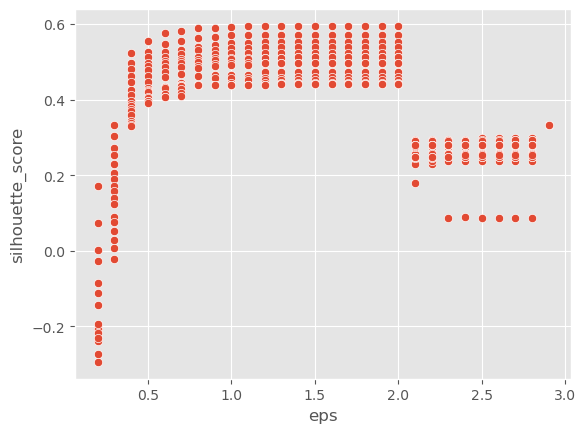

In [28]:
sns.scatterplot(x = score_db['eps'], y = score_db['silhouette_score']);

In [29]:
db = DBSCAN(eps = 1, min_samples = 15, n_jobs = 4).fit(dbscan_pipe.transform(X))
clustered = pd.concat([X, pd.Series(db.labels_, name = 'cluster')], axis = 1)
silhouette_score(dbscan_pipe.transform(X), clustered['cluster'])

0.5950785877973661

In [30]:
clustered['cluster'].value_counts() # Still a very large number of clusters and a tendency to have very small clusters
                                    # Additionally, 681 outliers are identified here

cluster
 23    1061
 2     1000
 20     981
 0      769
-1      681
       ... 
 21      16
 17      16
 33      16
 49      15
 61      15
Name: count, Length: 68, dtype: int64

In [31]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

agg_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

agg_clus = AgglomerativeClustering().fit(dbscan_pipe.transform(X))
clustered = pd.concat([X, pd.Series(agg_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(agg_pipe.transform(X), clustered['cluster'])

0.239801856746978

In [32]:
clustered['cluster'].value_counts()

cluster
1    5929
0    4847
Name: count, dtype: int64

In [33]:
score = []
for num_clusters in range(30, 155, 5):
    for linkage in ['ward', 'complete', 'average', 'single']:
        ag = AgglomerativeClustering(n_clusters = num_clusters, linkage = linkage) # type: ignore
    ag.fit(agg_pipe.transform(X))

    sil = silhouette_score(agg_pipe.transform(X), ag.labels_)

    score.append((num_clusters, linkage, sil))

score_db = pd.DataFrame(score, columns = ['n_cluster', 'linkage', 'silhouette_score'])

score_db.sort_values(by = ['silhouette_score'], ascending = False).head()

,n_cluster,linkage,silhouette_score
0,30,single,-0.058411
1,35,single,-0.067630
2,40,single,-0.127590
3,45,single,-0.138200
4,50,single,-0.144923


In [34]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

agg_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', StandardScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

agg_clus = AgglomerativeClustering().fit(dbscan_pipe.transform(X))
clustered = pd.concat([X, pd.Series(agg_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(agg_pipe.transform(X), clustered['cluster'])

0.11945677005215774

In [35]:
clustered['cluster'].value_counts()

cluster
1    5929
0    4847
Name: count, dtype: int64

c:\Users\vijay\anaconda3\envs\project-5\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


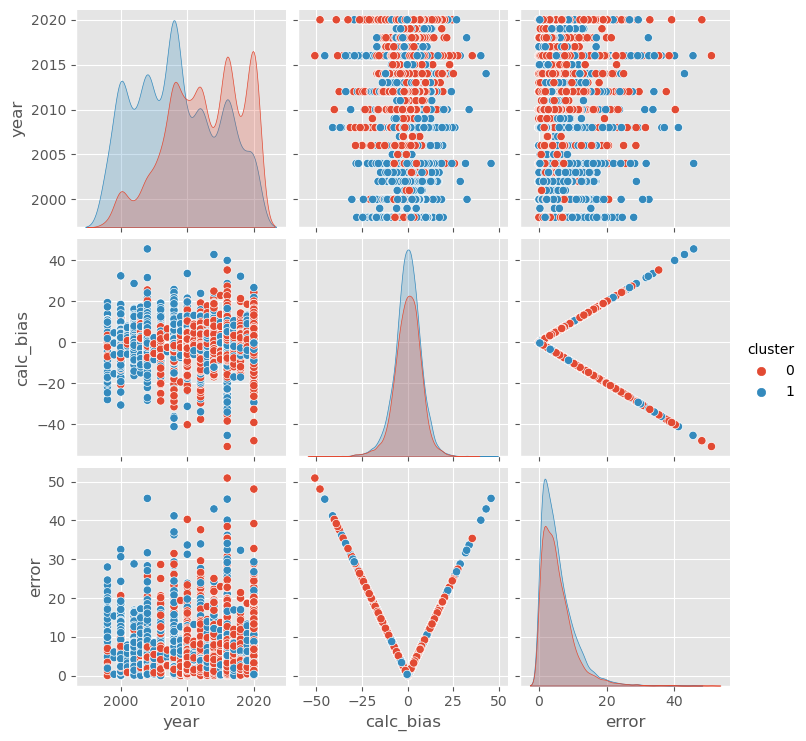

In [36]:
sns.pairplot(
    data = clustered[['year','calc_bias', 'error', 'cluster']],
    hue = 'cluster'
);

In [37]:
score = []
for num_clusters in range(2, 15):
    for linkage in ['ward', 'complete', 'average']:
        ag = AgglomerativeClustering(n_clusters = num_clusters, linkage = linkage) # type: ignore
        ag.fit(agg_pipe.transform(X))

        sil = silhouette_score(agg_pipe.transform(X), ag.labels_)

        score.append((num_clusters, linkage, sil))

score_db = pd.DataFrame(score, columns = ['n_cluster', 'linkage', 'silhouette_score'])

score_db.sort_values(by = ['silhouette_score'], ascending = False).head()

,n_cluster,linkage,silhouette_score
1,2,complete,0.899532
2,2,average,0.899532
5,3,average,0.746171
8,4,average,0.723714
7,4,complete,0.637739


In [38]:
agg_clus = AgglomerativeClustering(n_clusters = 6, linkage = 'average').fit(agg_pipe.transform(X))
clustered = pd.concat([X, pd.Series(agg_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(agg_pipe.transform(X), clustered['cluster'])

0.6248548010232662

In [39]:
clustered['cluster'].value_counts()

cluster
0    10743
2       22
1        7
5        2
3        1
4        1
Name: count, dtype: int64

In [40]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

aprop_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', StandardScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

aprop_clus = AffinityPropagation(random_state = 42).fit(aprop_pipe.transform(X))
clustered = pd.concat([X, pd.Series(aprop_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(aprop_pipe.transform(X), clustered['cluster'])

0.2535913044657091

In [41]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

mshift_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

mshift_clus = MeanShift(n_jobs = 6).fit(mshift_pipe.transform(X))
clustered = pd.concat([X, pd.Series(mshift_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(mshift_pipe.transform(X), clustered['cluster'])

0.31669875932400426

In [42]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

spec_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

spec_clus = SpectralClustering(random_state = 42, n_jobs = 4).fit(spec_pipe.transform(X))
clustered = pd.concat([X, pd.Series(spec_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(spec_pipe.transform(X), clustered['cluster'])

0.26706902734199556

In [11]:
partisaner = Pipeline(
    [
        ('ohe', OneHotEncoder(drop = 'first'))
    ]
)

hdb_pipe = Pipeline(
    [
        ('ct', ColumnTransformer(
            [
                ('patrisan_ct', partisaner, ['partisan', 'type_simple'])
            ],
            remainder = 'passthrough'
            )
        ),
        ('min_max', MinMaxScaler()),
        #('dbscan', DBSCAN(n_jobs = 4))
    ]
).fit(X)

hdb_clus = HDBSCAN(min_cluster_size = 5, min_samples = 40).fit(hdb_pipe.transform(X))
clustered = pd.concat([X, pd.Series(hdb_clus.labels_, name = 'cluster')], axis = 1)
silhouette_score(hdb_pipe.transform(X), clustered['cluster'])

0.44150698186544063